<a href="https://colab.research.google.com/github/AbdAllAh950/R-D/blob/main/U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [20]:
# Install necessary libraries
!pip install sentence-transformers
!pip install scikit-learn
!pip install vaderSentiment
!pip install wordcloud


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("keplaxo/twitter-vaccination-dataset")

print("Path to dataset files:", path)

100%|██████████| 305M/305M [00:07<00:00, 45.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/keplaxo/twitter-vaccination-dataset/versions/2


In [3]:
src="/root/.cache/kagglehub/datasets/keplaxo/twitter-vaccination-dataset/versions/2/master.csv"

In [19]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from datetime import datetime

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

# Text processing imports
from textblob import TextBlob

# Gensim imports
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore

# Sentence Transformers imports
from sentence_transformers import SentenceTransformer

# Scikit-learn imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
dataset = pd.read_csv(src)
print(dataset.head())

<ipython-input-5-ebd0493ceca6>:1: DtypeWarning: Columns (9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(src)


          id  conversation_id    created_at        date      time  \
0  1417693.0        1417693.0  1.166600e+12  20/12/2006  10:36:26   
1  3306733.0        3306733.0  1.169170e+12  19/01/2007  04:00:47   
2  5042833.0        5042833.0  1.170370e+12  02/02/2007  01:17:44   
3  5232473.0        5232473.0  1.170510e+12  03/02/2007  17:27:30   
4  5312417.0        5312417.0  1.170610e+12  04/02/2007  19:18:33   

                  timezone   user_id     username             name place  ...  \
0  E. Africa Standard Time   16053.0      sinenox              Cat   NaN  ...   
1  E. Africa Standard Time  621543.0    bbchealth  BBC Health News   NaN  ...   
2  E. Africa Standard Time  614623.0        clith             Reid   NaN  ...   
3  E. Africa Standard Time   68453.0      vivdora          Delia 💚   NaN  ...   
4  E. Africa Standard Time  717363.0  luxalptraum   Lux 📝 Alptraum   NaN  ...   

  quote_url video near geo  source  user_rt_id  user_rt retweet_id  \
0       NaN     0  NaN NaN  

In [6]:
dataset.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date'],
      dtype='object')

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2195108 entries, 0 to 2195107
Data columns (total 31 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               float64
 1   conversation_id  float64
 2   created_at       float64
 3   date             object 
 4   time             object 
 5   timezone         object 
 6   user_id          float64
 7   username         object 
 8   name             object 
 9   place            object 
 10  tweet            object 
 11  mentions         object 
 12  urls             object 
 13  photos           object 
 14  replies_count    int64  
 15  retweets_count   int64  
 16  likes_count      int64  
 17  hashtags         object 
 18  cashtags         object 
 19  link             object 
 20  retweet          bool   
 21  quote_url        object 
 22  video            int64  
 23  near             float64
 24  geo              float64
 25  source           float64
 26  user_rt_id       float64
 27  user_rt     

# Cleaning and Feature Selection

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)  # Remove URLs
    tweet = re.sub(r'\@\w+|\#', '', tweet)  # Remove mentions and hashtags
    tweet = tweet.lower()  # Convert to lowercase
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    return tweet.strip()

dataset["cleaned_tweet"] = dataset["tweet"].apply(clean_tweet)
dataset["date"] = pd.to_datetime(dataset["date"], format="%d/%m/%Y")

In [9]:
# Drop unnecessary columns
columns_to_drop = [
    'id', 'conversation_id', 'created_at', 'time', 'timezone', 'user_id', 'username',
    'name', 'place', 'urls', 'photos', 'cashtags', 'link', 'quote_url', 'retweet_id',
    'reply_to', 'retweet_date', 'user_rt_id', 'user_rt', 'near', 'geo'
]

In [10]:
dataset = dataset.drop(columns=columns_to_drop)

In [11]:
# Handling missing values by assigning back to the column
dataset['likes_count'] = dataset['likes_count'].fillna(0)
dataset['retweets_count'] = dataset['retweets_count'].fillna(0)
dataset['hashtags'] = dataset['hashtags'].fillna('')
dataset['mentions'] = dataset['mentions'].fillna('')

# For the 'date' column, we will drop rows with missing values
dataset.dropna(subset=['date'], inplace=True)

In [12]:
# Filter the dataset to include only data at 2019
dataset = dataset[(dataset["date"] >= "2019-01-01") & (dataset["date"] <= "2019-12-31")]

In [13]:
# Save the cleaned dataset
dataset.to_csv('cleaned_twitter_vaccine.csv', index=False)

# Descriptive Analysis & Sentiment Analysis

### Descriptive Analysis
explore some key insights from your data. We'll start with tweet counts over time and basic engagement metrics.

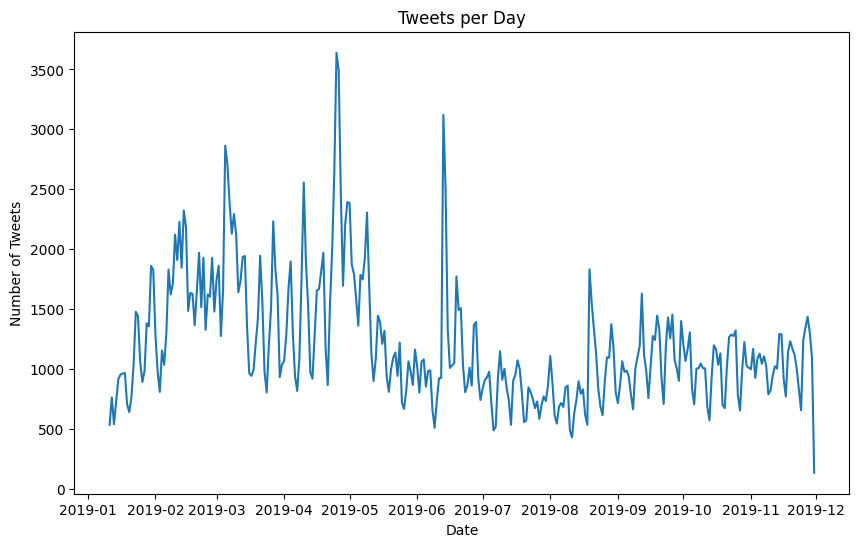

Average likes: 6.817041537950931, Average retweets: 2.4235722127192423


In [14]:
# Descriptive analysis: Tweet count by date
tweets_by_date = dataset.groupby(dataset['date'].dt.date).size()
tweets_by_date.plot(kind='line', title="Tweets per Day", figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.savefig('Tweet count by date.png', dpi=300, bbox_inches='tight')  # Replace 'plot_name' with a meaningful name
plt.show()

# Descriptive analysis: Average engagement (likes and retweets)
avg_engagement = dataset[['likes_count', 'retweets_count']].mean()
print(f"Average likes: {avg_engagement['likes_count']}, Average retweets: {avg_engagement['retweets_count']}")


In [15]:
# Descriptive analysis: Average engagement (likes and retweets)
avg_engagement = dataset[['likes_count', 'retweets_count']].mean()
print(f"Average likes: {avg_engagement['likes_count']}, Average retweets: {avg_engagement['retweets_count']}")


Average likes: 6.817041537950931, Average retweets: 2.4235722127192423


### Sentiment Analysis
sentiment analysis using VADER to categorize tweets as positive, neutral, or negative

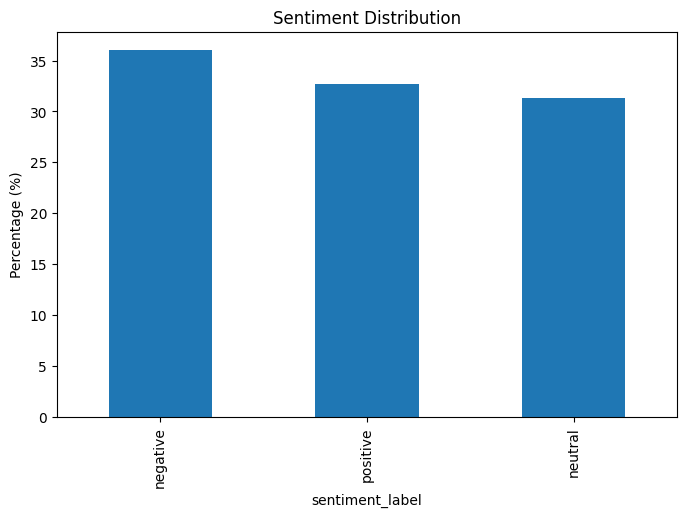

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis on tweets
dataset['sentiment'] = dataset['cleaned_tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Categorize sentiments
dataset['sentiment_label'] = dataset['sentiment'].apply(lambda x: 'positive' if x > 0.1 else ('negative' if x < -0.1 else 'neutral'))

# Sentiment distribution visualization
sentiment_dist = dataset['sentiment_label'].value_counts(normalize=True) * 100
sentiment_dist.plot(kind='bar', title="Sentiment Distribution", figsize=(8, 5))
plt.ylabel("Percentage (%)")
plt.savefig('Sentiment distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Save Sentiment Analysis Results
dataset[['tweet', 'sentiment', 'sentiment_label']].to_csv('sentiment_analysis.csv', index=False)

# Efficient Topic Modeling Using Pre-trained Embeddings

In this notebook, we employ a modern and efficient approach for topic modeling
by leveraging pre-trained sentence embeddings and clustering algorithms like KMeans.
This method offers several advantages over traditional techniques like Latent Dirichlet Allocation (LDA):

1. **Higher Semantic Quality**: Pre-trained models such as BERT capture semantic meaning,
enabling the clustering of tweets based on contextual similarity rather than just word frequency.
2. **Speed and Scalability**: Generating embeddings with Sentence Transformers is faster,
especially for large datasets, and KMeans clustering scales well with high-dimensional data.
3. **Simplified Process**: Unlike LDA, which requires extensive hyperparameter tuning and multiple iterations,
this approach is straightforward and produces high-quality results with minimal effort.
4. **Visual Insights**: The use of dimensionality reduction techniques like PCA allows us to
visualize clusters effectively, providing deeper insights into tweet topics.

This implementation showcases how pre-trained models and clustering techniques can streamline the topic modeling process, making it both faster and more insightful.


In [21]:
# Load your dataset (replace with your dataset path or existing DataFrame)
dataset = pd.read_csv('cleaned_twitter_vaccine.csv')

# Load pre-trained sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Ensure all elements in 'cleaned_tweet' are strings before encoding
dataset['cleaned_tweet'] = dataset['cleaned_tweet'].astype(str)

# Generate embeddings for the cleaned tweets
tweet_embeddings = model.encode(dataset['cleaned_tweet'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/12241 [00:00<?, ?it/s]

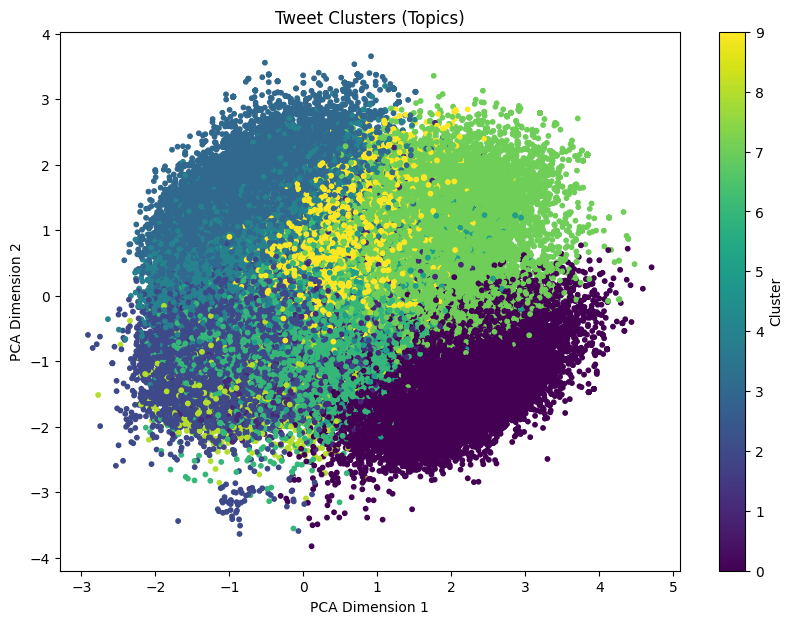

In [30]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tweet_embeddings)

# Assuming you have performed KMeans clustering and stored the cluster labels in 'labels'
# Replace 'n_clusters' with the actual number of clusters you used in KMeans
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
dataset['topic'] = kmeans.fit_predict(tweet_embeddings)


# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=dataset['topic'], cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title('Tweet Clusters (Topics)')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.savefig('the clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391690 entries, 0 to 391689
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tweet            391690 non-null  object 
 1   sentiment        391690 non-null  float64
 2   sentiment_label  391690 non-null  object 
 3   topic            391690 non-null  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 10.5+ MB


In [25]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(dataset['cleaned_tweet'])

# Function to get top words per cluster
def get_top_words_per_cluster(X, labels, terms, top_n=10):
    cluster_top_words = {}
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)
        cluster_data = X[cluster_indices].sum(axis=0).A1
        top_terms = cluster_data.argsort()[-top_n:][::-1]
        cluster_top_words[cluster_id] = [terms[i] for i in top_terms]
    return cluster_top_words

# Get the top words for each cluster
top_words = get_top_words_per_cluster(X, dataset['topic'], vectorizer.get_feature_names_out())
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: antivaccination, facebook, misinformation, movement, trolls, youtube, russian, spreading, propaganda, groups
Cluster 1: vaccination, flu, health, vaccine, rabies, today, free, influenza, need, vaccines
Cluster 2: vaccination, mandatory, rates, health, exemptions, vaccines, new, vaccine, people, forced
Cluster 3: hpv, cancer, cervical, vaccination, girls, papillomavirus, women, rates, vaccine, cancers
Cluster 4: measles, vaccination, outbreak, cases, outbreaks, rates, antivaccination, health, new, children
Cluster 5: polio, vaccination, pakistan, children, campaign, drive, health, vaccine, peshawar, tactics
Cluster 6: vaccination, children, child, kids, parents, autism, school, vaccines, vaccinated, dont
Cluster 7: vaccination, people, dont, vaccines, like, just, vaccine, science, think, anti
Cluster 8: la, les, le, et, des, en, pour, vaccination, contre, pas
Cluster 9: vaccination, flu, anti, need, just, im, forced, got, like, rabies


In [36]:
dataset_c = pd.read_csv('cleaned_twitter_vaccine.csv')
dataset_c['topic'] = dataset['topic']


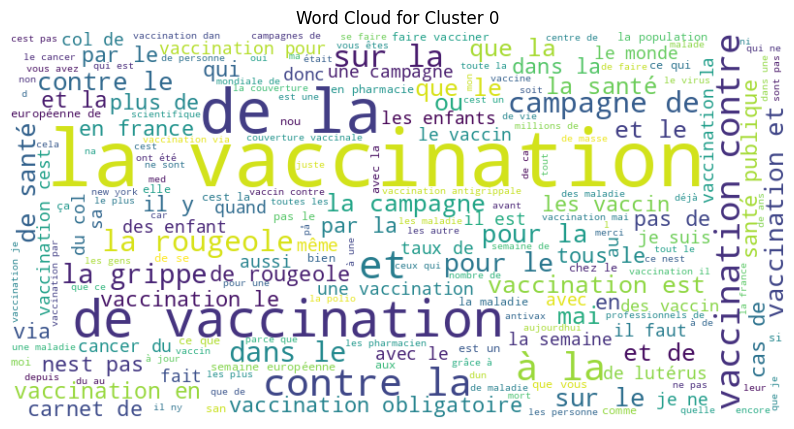

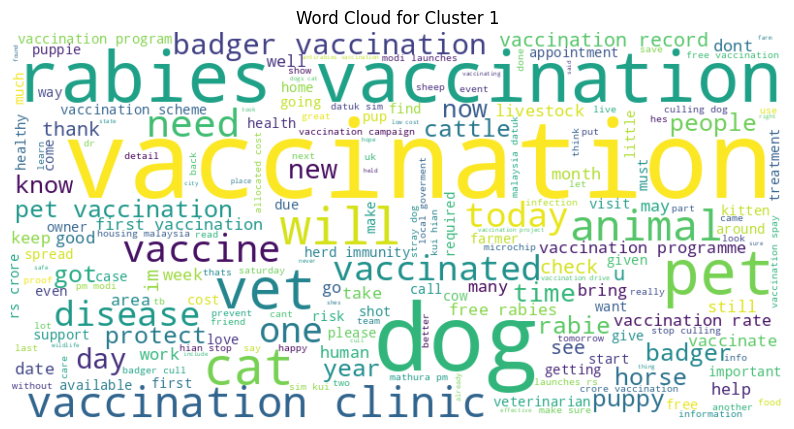

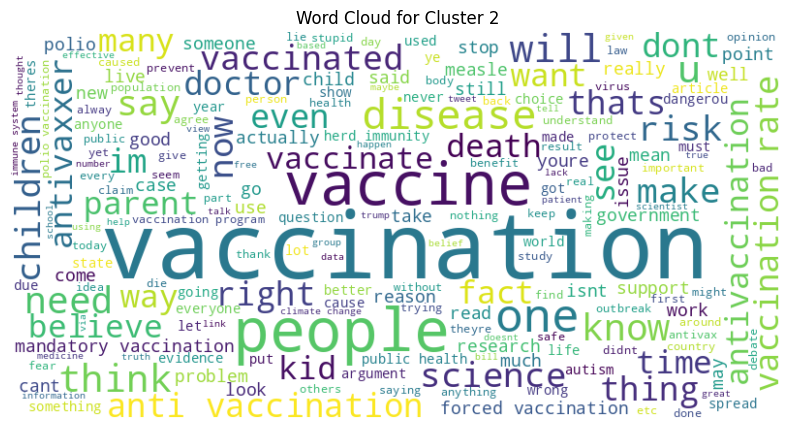

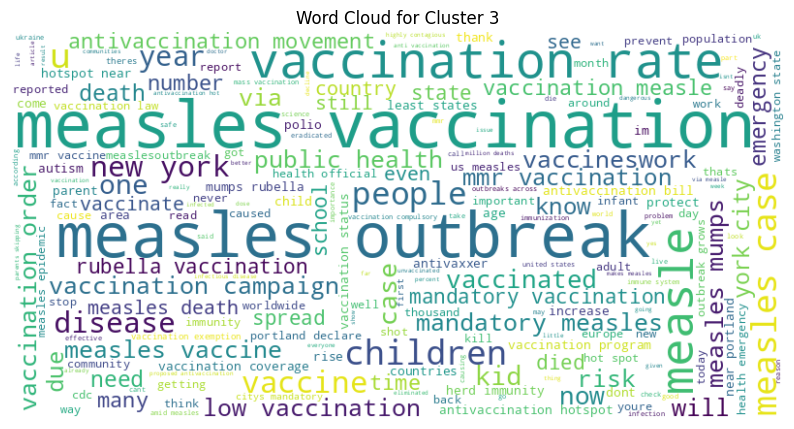

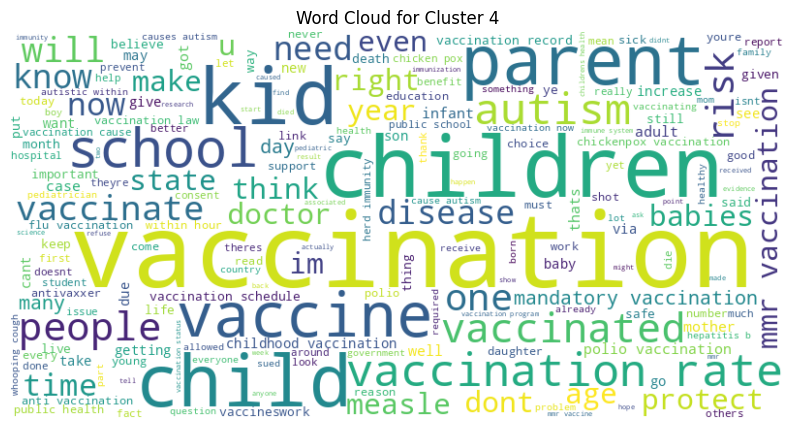

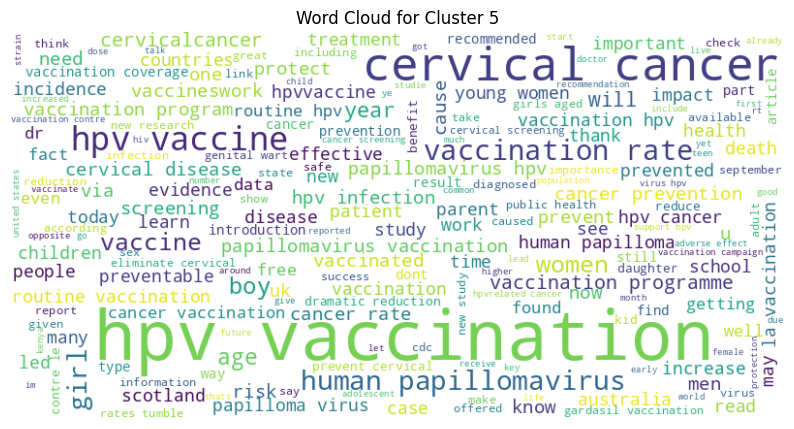

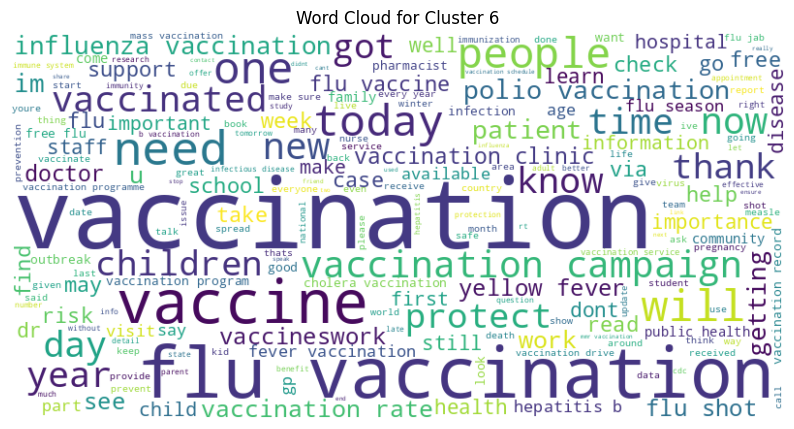

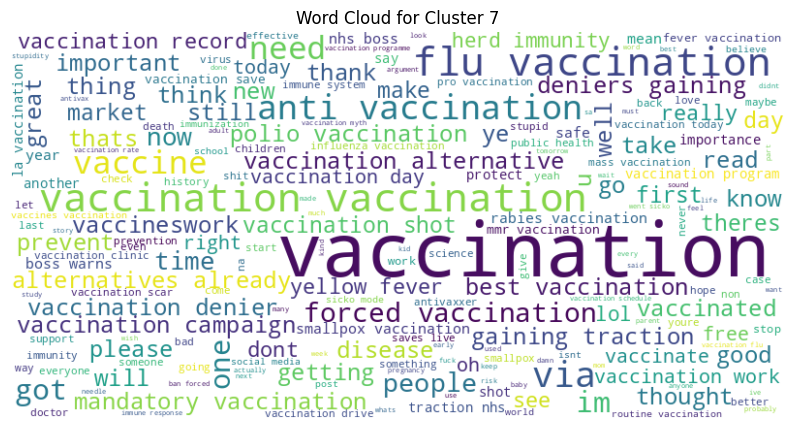

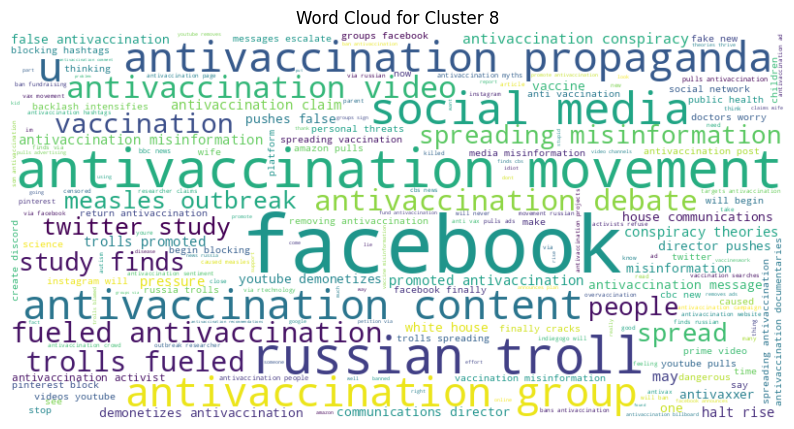

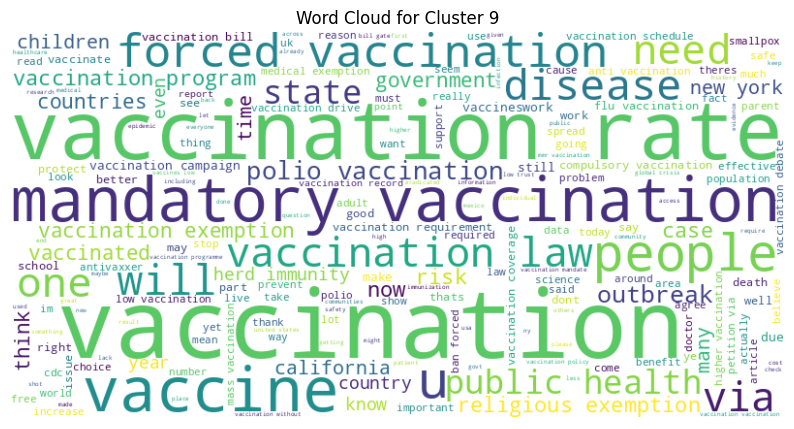

In [38]:
for cluster_id in np.unique(dataset_c['topic']):
    # Convert all elements in the 'cleaned_tweet' column to strings
    cluster_text = " ".join(dataset_c[dataset_c['topic'] == cluster_id]['cleaned_tweet'].astype(str))
    wordcloud = WordCloud(background_color='white', colormap='viridis', width=800, height=400).generate(cluster_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.savefig('WordCloud.png', dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
# Save dataset with topics
dataset.to_csv('clustered_tweets.csv', index=False)

# Summarize cluster information
summary = {
    'Cluster': [],
    'Size': [],
    'Top Words': [],
}

for cluster, words in top_words.items():
    summary['Cluster'].append(cluster)
    summary['Size'].append((dataset['topic'] == cluster).sum())
    summary['Top Words'].append(", ".join(words[:5]))

summary_df = pd.DataFrame(summary)
summary_df.to_csv('cluster_summary.csv', index=False)

print(summary_df)


   Cluster   Size                                          Top Words
0        0  33177  antivaccination, facebook, misinformation, mov...
1        1  17954          vaccination, flu, health, vaccine, rabies
2        2  75579  vaccination, mandatory, rates, health, exemptions
3        3  34792          hpv, cancer, cervical, vaccination, girls
4        4  53825   measles, vaccination, outbreak, cases, outbreaks
5        5  13519   polio, vaccination, pakistan, children, campaign
6        6  66949        vaccination, children, child, kids, parents
7        7  33354          vaccination, people, dont, vaccines, like
8        8  17475                               la, les, le, et, des
9        9  45066                 vaccination, flu, anti, need, just
